Using device: cpu
Generating spiral data...
Initializing model...
Score model parameters: 165634
Training score model...


Training:  30%|████████████████████████████████████████▎                                                                                               | 296/1000 [00:00<00:00, 752.14it/s]

Epoch 200, Loss: 57.518780


Training:  52%|███████████████████████████████████████████████████████████████████████▎                                                                | 524/1000 [00:00<00:00, 689.01it/s]

Epoch 400, Loss: 27.464203


Training:  67%|███████████████████████████████████████████████████████████████████████████████████████████                                             | 670/1000 [00:00<00:00, 708.43it/s]

Epoch 600, Loss: 106.629501


Training:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 888/1000 [00:01<00:00, 705.00it/s]

Epoch 800, Loss: 12.813740


Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 712.31it/s]


Epoch 1000, Loss: 19.497156
Generating samples...


Sampling: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 955.99it/s]


Plotting results...


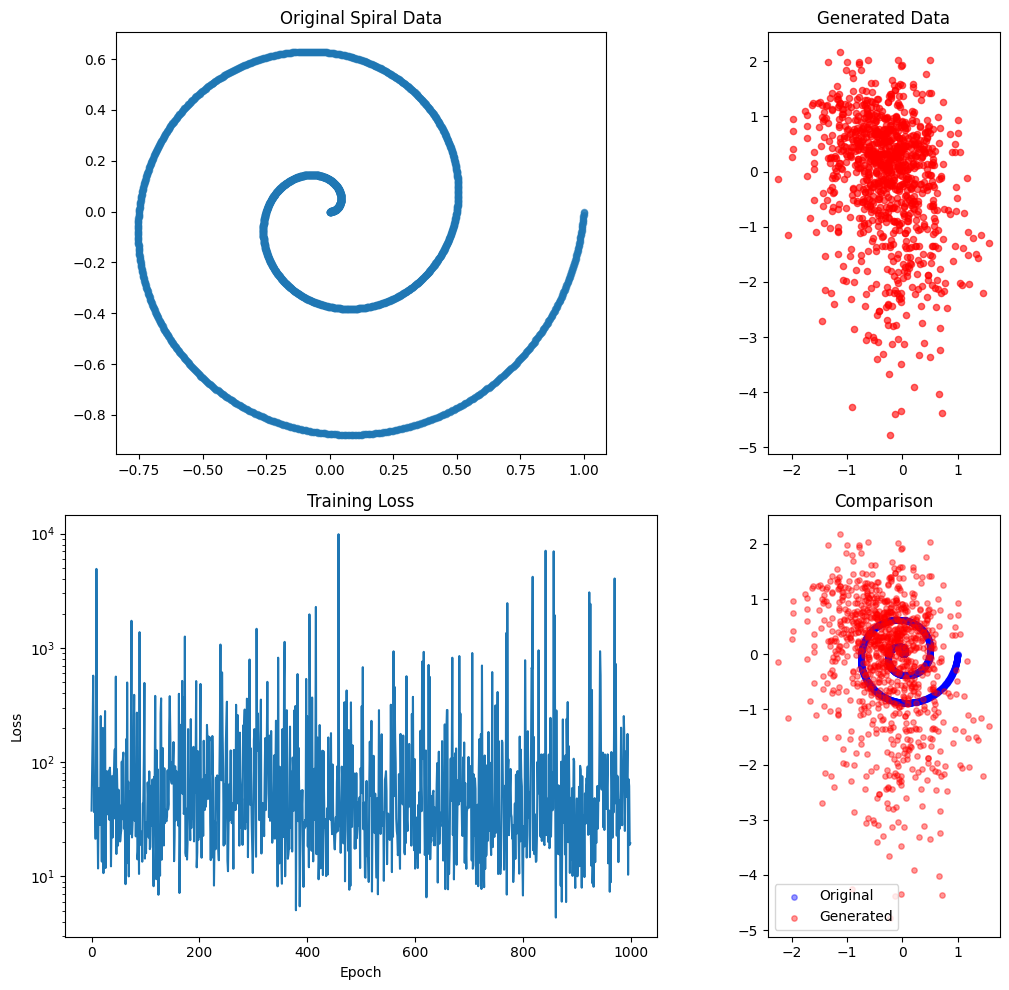

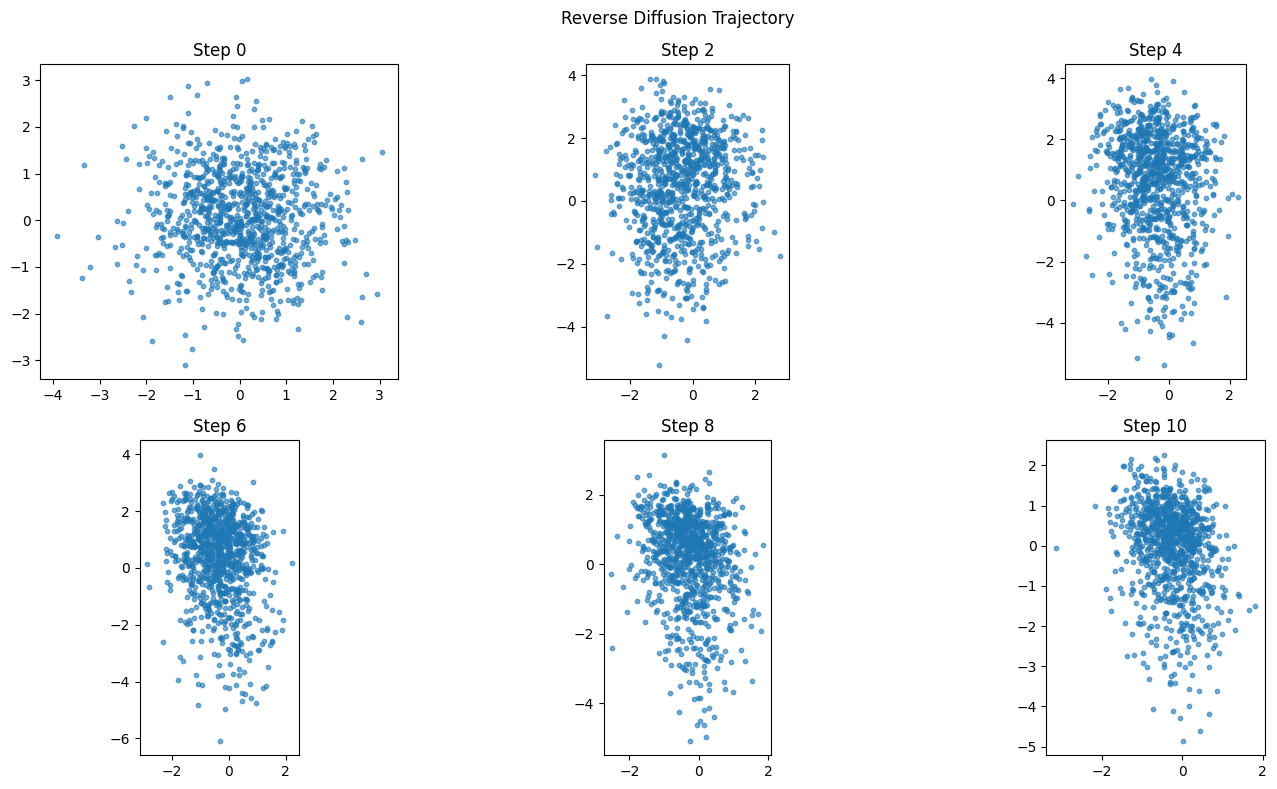

Done!


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Generate spiral data
def generate_spiral_data(n_samples=1000):
    """Generate 2D spiral dataset"""
    t = np.linspace(0, 4*np.pi, n_samples)
    x = t * np.cos(t) / (4*np.pi)
    y = t * np.sin(t) / (4*np.pi)
    data = np.column_stack([x, y])
    return torch.FloatTensor(data)

# Time embedding using sinusoidal encoding
class TimeEmbedding(nn.Module):
    def __init__(self, embed_dim=128):
        super().__init__()
        self.embed_dim = embed_dim
        
    def forward(self, t):
        """
        Args:
            t: (batch_size,) tensor of time values
        Returns:
            (batch_size, embed_dim) tensor of time embeddings
        """
        half_dim = self.embed_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        return emb

# Score Network (approximates the Stein score function)
class ScoreNetwork(nn.Module):
    def __init__(self, data_dim=2, time_embed_dim=128, hidden_dim=256):
        super().__init__()
        self.data_dim = data_dim
        self.time_embedding = TimeEmbedding(time_embed_dim)
        
        # Network to process concatenated data and time embedding
        self.net = nn.Sequential(
            nn.Linear(data_dim + time_embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, data_dim)
        )
        
    def forward(self, x, t):
        """
        Args:
            x: (batch_size, data_dim) data points
            t: (batch_size,) time values
        Returns:
            (batch_size, data_dim) score estimates
        """
        # Get time embeddings
        t_emb = self.time_embedding(t)
        
        # Concatenate data and time embedding
        h = torch.cat([x, t_emb], dim=-1)
        
        # Predict score
        score = self.net(h)
        return score

# Variance Preserving SDE
class VPSDE:
    def __init__(self, beta_min=0.1, beta_max=20.0, T=1.0):
        """
        Variance Preserving SDE: dx = -1/2 * β(t) * x dt + √β(t) dw
        
        Args:
            beta_min: minimum noise schedule value
            beta_max: maximum noise schedule value  
            T: terminal time
        """
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.T = T
        
    def beta(self, t):
        """Linear noise schedule β(t)"""
        return self.beta_min + t * (self.beta_max - self.beta_min)
    
    def mean_coeff(self, t):
        """Mean coefficient for q(x_t | x_0)"""
        integral = self.beta_min * t + 0.5 * (self.beta_max - self.beta_min) * t**2
        return torch.exp(-0.5 * integral)
    
    def var_coeff(self, t):
        """Variance coefficient for q(x_t | x_0)"""
        integral = self.beta_min * t + 0.5 * (self.beta_max - self.beta_min) * t**2
        return 1.0 - torch.exp(-integral)
    
    def sample_q(self, x0, t):
        """
        Sample from q(x_t | x_0) = N(x_t; α(t)x_0, σ²(t)I)
        where α(t) = mean_coeff(t), σ²(t) = var_coeff(t)
        """
        batch_size = x0.shape[0]
        
        # Ensure t is the right shape
        if t.dim() == 0:
            t = t.expand(batch_size)
        elif t.shape[0] != batch_size:
            t = t.expand(batch_size)
            
        mean_coeff = self.mean_coeff(t).view(-1, 1)
        var_coeff = self.var_coeff(t).view(-1, 1)
        
        noise = torch.randn_like(x0)
        xt = mean_coeff * x0 + torch.sqrt(var_coeff) * noise
        
        return xt, noise

# Training function
def train_score_model(score_model, sde, data, n_epochs=1000, batch_size=256, lr=1e-3):
    """Train the score model using denoising score matching"""
    optimizer = optim.Adam(score_model.parameters(), lr=lr)
    
    losses = []
    
    for epoch in tqdm(range(n_epochs), desc="Training"):
        # Sample batch
        idx = torch.randperm(len(data))[:batch_size]
        x0 = data[idx].to(device)
        
        # Sample random times
        t = torch.rand(batch_size, device=device) * sde.T
        
        # Forward diffusion: sample q(x_t | x_0)
        xt, noise = sde.sample_q(x0, t)
        
        # Predict score
        score_pred = score_model(xt, t)
        
        # True score for q(x_t | x_0) is -noise / σ(t)
        var_coeff = sde.var_coeff(t).view(-1, 1)
        score_true = -noise / torch.sqrt(var_coeff)
        
        # Loss: || s_θ(x_t, t) - ∇log q(x_t | x_0) ||²
        loss = torch.mean(torch.sum((score_pred - score_true) ** 2, dim=-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}, Loss: {loss.item():.6f}")
    
    return losses

# Sampling using reverse SDE
def sample_reverse_sde(score_model, sde, n_samples=1000, n_steps=1000):
    """Sample from the model using reverse SDE with Euler-Maruyama"""
    
    # Start from noise
    x = torch.randn(n_samples, 2, device=device)
    dt = sde.T / n_steps
    sqrt_dt = math.sqrt(dt)
    
    trajectory = [x.detach().cpu().numpy()]
    
    with torch.no_grad():
        for i in tqdm(range(n_steps), desc="Sampling"):
            t = torch.ones(n_samples, device=device) * (sde.T - i * dt)
            
            # Predict score
            score = score_model(x, t)
            
            # Reverse SDE: dx = [1/2 * β(t) * x + β(t) * s_θ(x,t)] dt + √β(t) dw
            beta_t = sde.beta(t).view(-1, 1)
            drift = 0.5 * beta_t * x + beta_t * score
            diffusion = torch.sqrt(beta_t)
            
            # Euler-Maruyama step
            noise = torch.randn_like(x)
            x = x + drift * dt + diffusion * sqrt_dt * noise
            
            # Store trajectory (every 50 steps to save memory)
            if i % 50 == 0:
                trajectory.append(x.detach().cpu().numpy())
    
    return x.detach().cpu().numpy(), trajectory

# Visualization functions
def plot_results(original_data, generated_data, losses, trajectory=None):
    """Plot training results and generated samples"""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original data
    axes[0, 0].scatter(original_data[:, 0], original_data[:, 1], alpha=0.6, s=20)
    axes[0, 0].set_title('Original Spiral Data')
    axes[0, 0].set_aspect('equal')
    
    # Generated data
    axes[0, 1].scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.6, s=20, color='red')
    axes[0, 1].set_title('Generated Data')
    axes[0, 1].set_aspect('equal')
    
    # Training loss
    axes[1, 0].plot(losses)
    axes[1, 0].set_title('Training Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_yscale('log')
    
    # Comparison
    axes[1, 1].scatter(original_data[:, 0], original_data[:, 1], alpha=0.4, s=15, label='Original', color='blue')
    axes[1, 1].scatter(generated_data[:, 0], generated_data[:, 1], alpha=0.4, s=15, label='Generated', color='red')
    axes[1, 1].set_title('Comparison')
    axes[1, 1].set_aspect('equal')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Plot sampling trajectory if provided
    if trajectory is not None:
        plot_sampling_trajectory(trajectory)

def plot_sampling_trajectory(trajectory):
    """Plot the reverse diffusion trajectory"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    # Show trajectory at different time steps
    steps_to_show = [0, len(trajectory)//5, 2*len(trajectory)//5, 3*len(trajectory)//5, 4*len(trajectory)//5, -1]
    
    for i, step_idx in enumerate(steps_to_show):
        if i < len(axes):
            data = trajectory[step_idx]
            axes[i].scatter(data[:, 0], data[:, 1], alpha=0.6, s=10)
            axes[i].set_title(f'Step {step_idx if step_idx >= 0 else len(trajectory)-1}')
            axes[i].set_aspect('equal')
            
    plt.suptitle('Reverse Diffusion Trajectory')
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    # Generate spiral data
    print("Generating spiral data...")
    spiral_data = generate_spiral_data(n_samples=2000)
    
    # Initialize model and SDE
    print("Initializing model...")
    score_model = ScoreNetwork(data_dim=2, time_embed_dim=128, hidden_dim=256).to(device)
    sde = VPSDE(beta_min=0.1, beta_max=20.0, T=1.0)
    
    print(f"Score model parameters: {sum(p.numel() for p in score_model.parameters())}")
    
    # Train the model
    print("Training score model...")
    losses = train_score_model(score_model, sde, spiral_data, n_epochs=1000, batch_size=256, lr=1e-3)
    
    # Generate samples
    print("Generating samples...")
    generated_samples, trajectory = sample_reverse_sde(score_model, sde, n_samples=1000, n_steps=500)
    
    # Plot results
    print("Plotting results...")
    plot_results(spiral_data.numpy(), generated_samples, losses, trajectory)
    
    print("Done!")